# AskReddit

## Functions

### Feature Importance

In [60]:
import pandas as pd
from scripts import Munger as mg
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
import matplotlib.pyplot as plt

def feature_importance(train, test, features, predict, trees=10, state=None):
    
    X = train[features]
    y = train[predict]

    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=trees,
                                  random_state=state)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print '%d.' % (f + 1), X.columns.values[indices[f]], '(%f)' % importances[indices[f]]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), [ X.columns.values[i] for i in indices], rotation=75)
    plt.xlim([-1, X.shape[1]])
    plt.show()

    X = test[features]
    y = test[predict]

    print 'Score:', forest.score(X,y)
    
    return forest

### TFIDF Vectorization

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorize(train, test, maxdf=0.8, mindf=0.05):
    tfidf = TfidfVectorizer(stop_words='english', max_df=maxdf, min_df=mindf)

    train_tfidf = tfidf.fit_transform(train)
    test_tfidf = tfidf.transform(test)
    
    return {'train_tfidf': train_tfidf,'test_tfidf': test_tfidf}

### Clustering

In [76]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def cluster(train, test, clusters=10, iterations=300, init=10):
    km = KMeans(n_clusters=clusters, init='k-means++', max_iter=iterations, n_init=init)

    train_preds = km.fit_predict(train)
    test_preds = km.predict(test)
    
    return {'train_preds': train_preds, 'test_preds': test_preds}

### Full Function

In [61]:
def show_feature_importance(train_filename, test_filename, features, predict):
    # Load datasets
    train = pd.read_csv(train_filename)
    test = pd.read_csv(test_filename)

    # Munge data
    train = mg.munge_dataset(train)
    test = mg.munge_dataset(test)

    if 'watson cluster' in features:
        # Create Watson Vector
        watson = ['Watson Anger', 'Watson Disgust', 'Watson Fear',
                   'Watson Joy', 'Watson Sadness', 'Watson Analytical',
                   'Watson Confident', 'Watson Tenative', 'Watson Openness',
                   'Watson Conscientiousness', 'Watson Extraversion',
                   'Watson Agreeableness', 'Watson Emotional Range'] 
        train_watson_vector = train[watson].values
        test_watson_vector = test[watson].values

        # Cluster by Watson Vector
        preds = cluster(train_watson_vector, test_watson_vector, 200, 300, 10)
        train['watson cluster'] = preds['train_preds']
        test['watson cluster'] = preds['test_preds']

    if 'body cluster' in features:
        # Create TFIDF vector for body
        tfidf = tfidf_vectorize(train['body'], test['body'], maxdf=0.8, mindf=0.05)
        train_tfidf = tfidf['train_tfidf']
        test_tfidf = tfidf['train_tfidf']

        # Cluster by Body TFIDF Vector
        preds = cluster(train_tfidf, test_tfidf, 200, 300, 10)
        train['body cluster'] = preds['train_preds']
        test['body cluster'] = preds['test_preds']

    # Map gilded to boolean
    train['gilded'] = train['gilded'].astype(bool)
    test['gilded'] = test['gilded'].astype(bool)

    # Print feature importance
    return feature_importance(train, test, features, predict, trees=250, state=None)

## Gilded Feature Analysis

Feature ranking:
1. Score Bracket (0.892989)
2. Time of Day (0.076978)
3. Contains MD (0.030033)


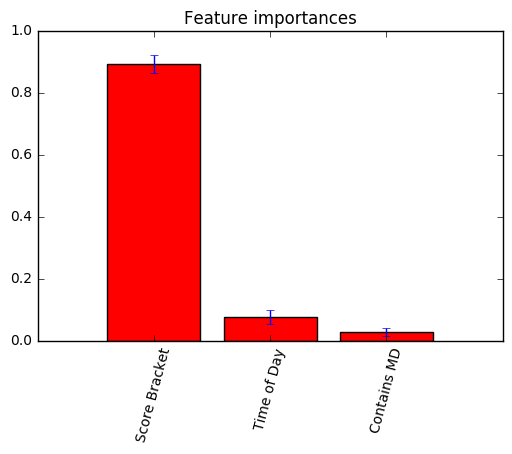

Score: 0.735


In [81]:
features = [
    'Score Bracket', 
    'Contains MD', 
#     'Word Count', 
    'Time of Day', 
#     'watson cluster',
#     'body cluster',
#     'Grammer Errors',
#     'Sentiment Label',
#     'flair',
#     'Watson Anger', 
#     'Watson Disgust', 
#     'Watson Fear',
#     'Watson Joy', 
#     'Watson Sadness', 
#     'Watson Analytical',
#     'Watson Confident', 
#     'Watson Tenative', 
#     'Watson Openness',
#     'Watson Conscientiousness', 
#     'Watson Extraversion',
#     'Watson Agreeableness', 
#     'Watson Emotional Range'
]

gilded = show_feature_importance('./mytrain/addedAskReddit_train.csv', 
                        './mytest/addedAskReddit_test.csv', 
                        features, 
                        'gilded')

## Score Bracket Feature Analyis

Feature ranking:
1. Word Count (0.097633)
2. Watson Disgust (0.095815)
3. Watson Joy (0.087571)
4. Watson Sadness (0.082374)
5. Watson Anger (0.081380)
6. Watson Fear (0.080614)
7. body cluster (0.080603)
8. Watson Openness (0.080055)
9. Watson Conscientiousness (0.079573)
10. Watson Emotional Range (0.079075)
11. Watson Agreeableness (0.078673)
12. Watson Extraversion (0.076634)


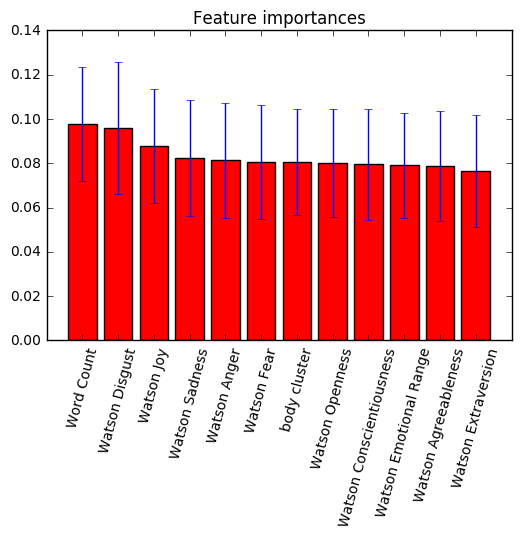

Score: 0.795


In [88]:
features = [
#     'Contains MD', 
    'Word Count', 
#     'Time of Day', 
#     'watson cluster',
    'body cluster',
#     'Grammer Errors',
#     'Sentiment Label',
#     'flair',
    'Watson Anger', 
    'Watson Disgust', 
    'Watson Fear',
    'Watson Joy', 
    'Watson Sadness', 
#     'Watson Analytical',
#     'Watson Confident', 
#     'Watson Tenative', 
    'Watson Openness',
    'Watson Conscientiousness', 
    'Watson Extraversion',
    'Watson Agreeableness', 
    'Watson Emotional Range'
]

scoreb = show_feature_importance('./mytrain/addedAdviceAnimals_train.csv', 
                        './mytest/addedAdviceAnimals_test.csv', 
                        features, 
                        'Score Bracket')

## Saving Classifiers

In [82]:
import pickle

with open("classifiers/AskReddit_gilded.pickle",'wb') as f:
    pickle.dump(gilded, f) # saves classifier to file
    
with open("classifiers/AskReddit_score.pickle",'wb') as f:
    pickle.dump(scoreb, f) # saves classifier to file